# Project Statement

## Initialization

In [1]:
import math
import re
import spacy
import torch
import transformers
from transformers import BertTokenizer, BertModel

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from lightgbm import LGBMClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm, tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

no nulls

In [7]:
df_reviews.duplicated().sum()

0

no duplicates

In [8]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Well done!
</div>

## EDA

Let's check the number of movies and reviews over years.

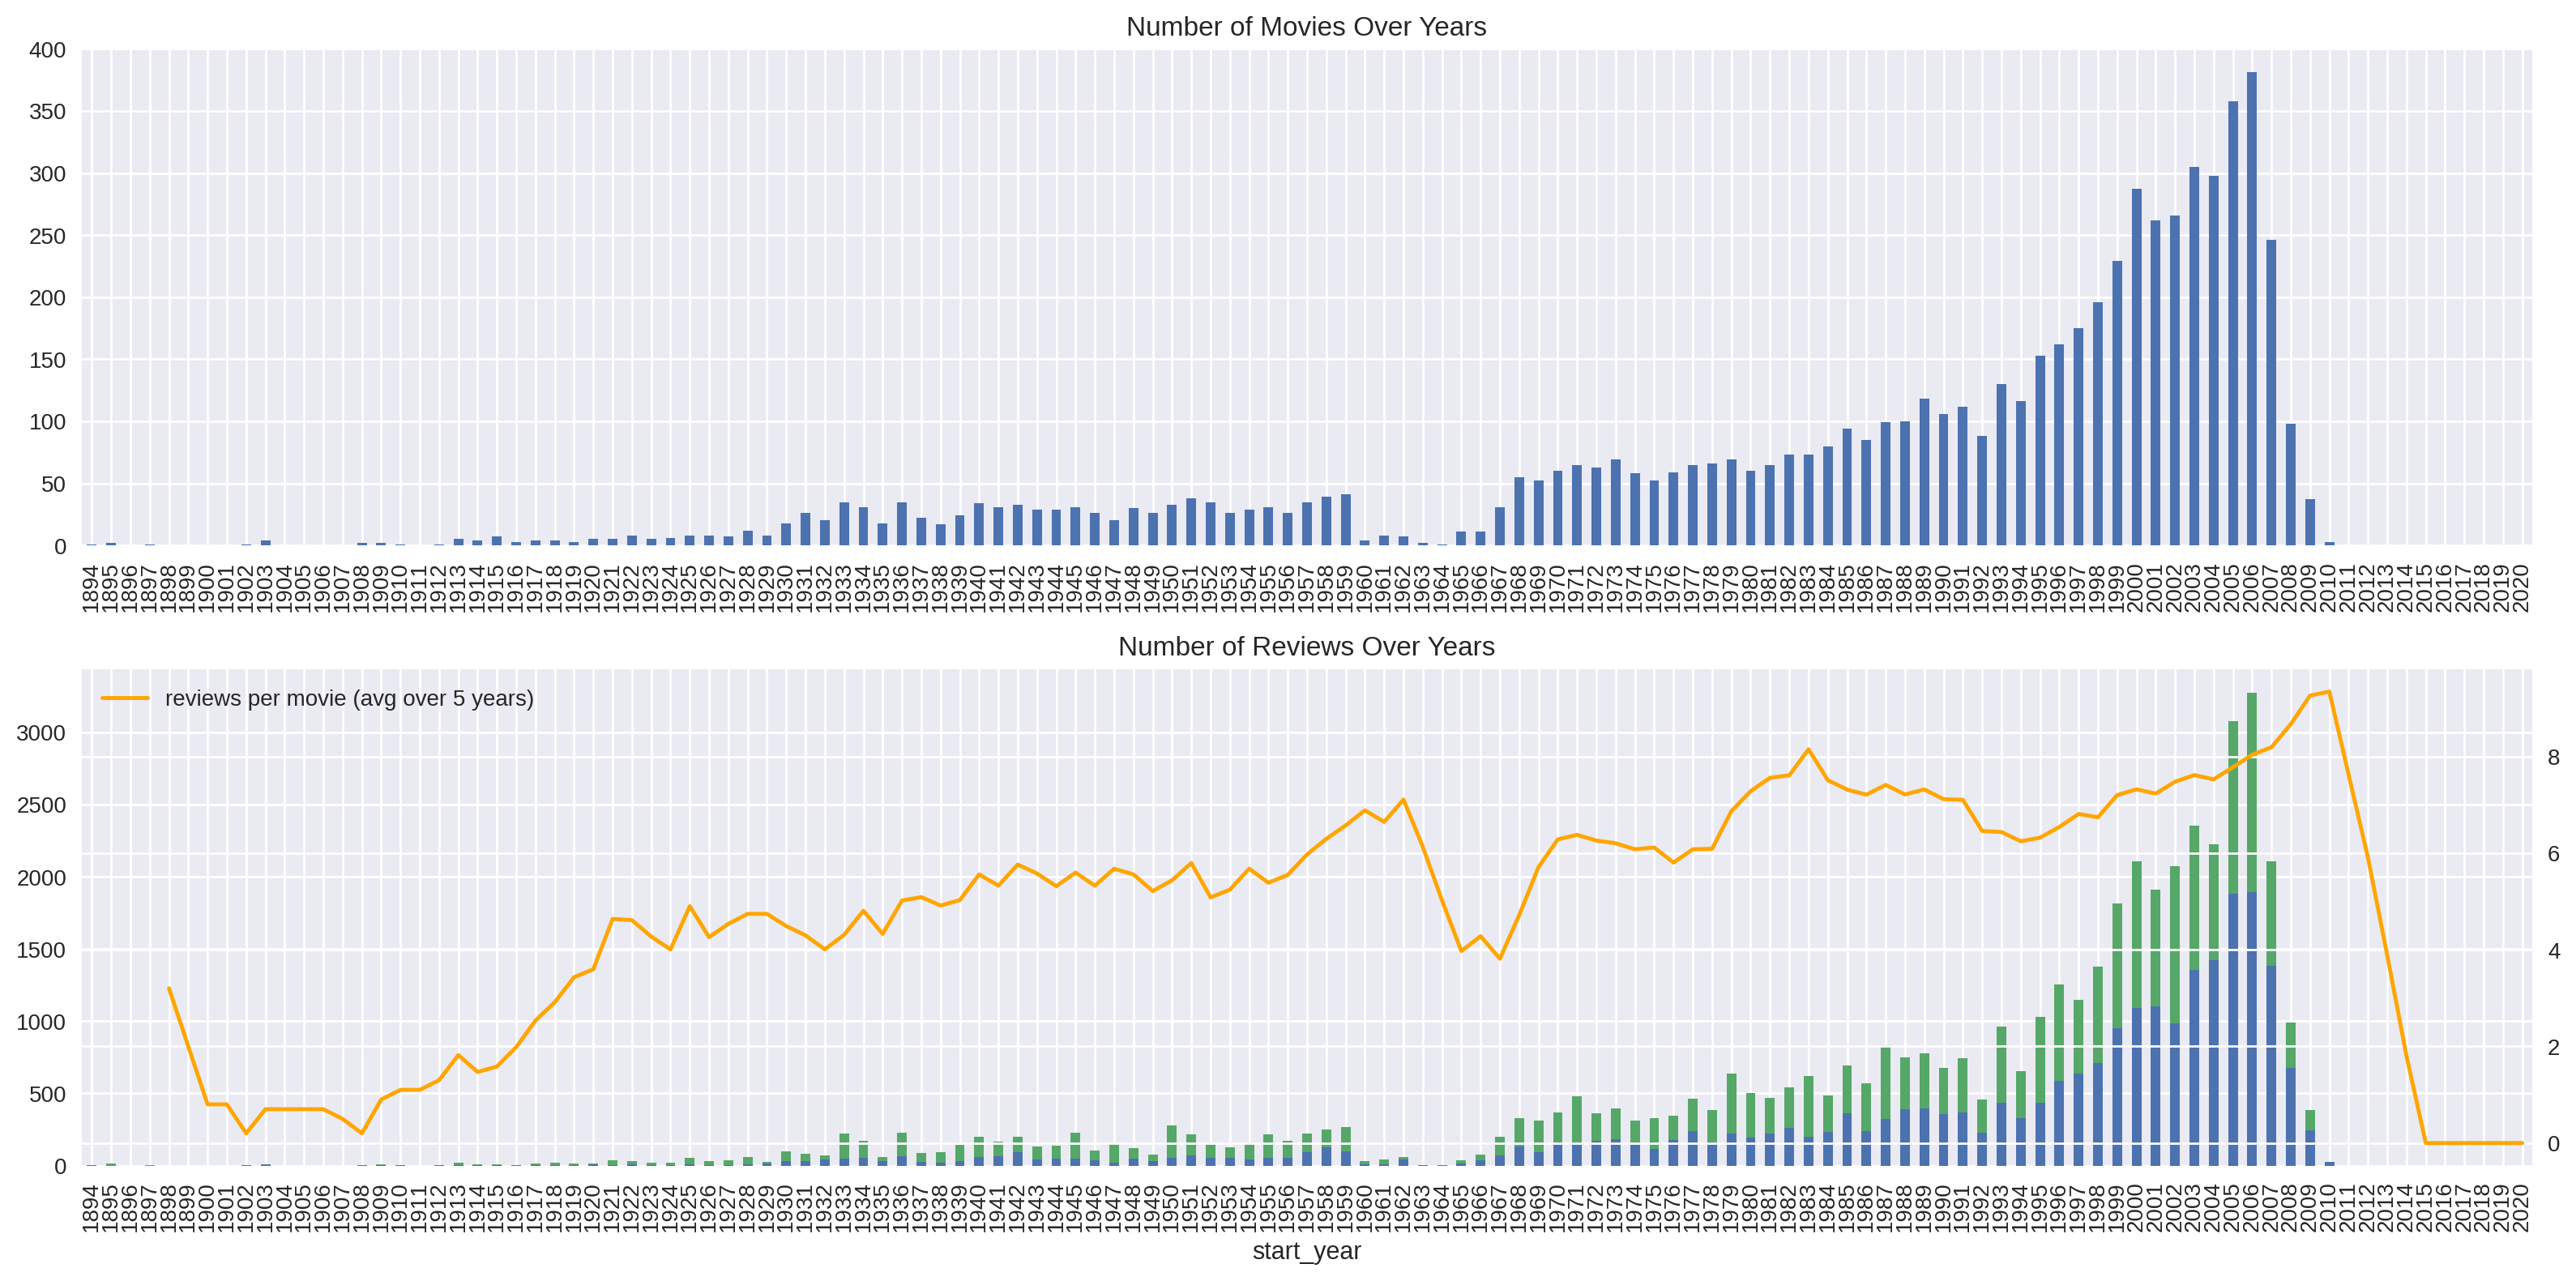

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The above graphs allow us to visualize the number of movies released and reviews made each year. The first plot shows the total movies released per year, while the second plot shows the average yearly movie reviews, with positive reviews in green and negative in blue; additionally, the second plot shows a rolling average of review per movie within a 5 year window.

As we see, the information in our DataFrame suggests that 2006 was the year with the most movies released. This alings with the year with the most movie reviews made. The number of movies released sharply declined after 2006, which roughly coincides with the financial crisis of 2008; the total number of reviews made followed the same trend.

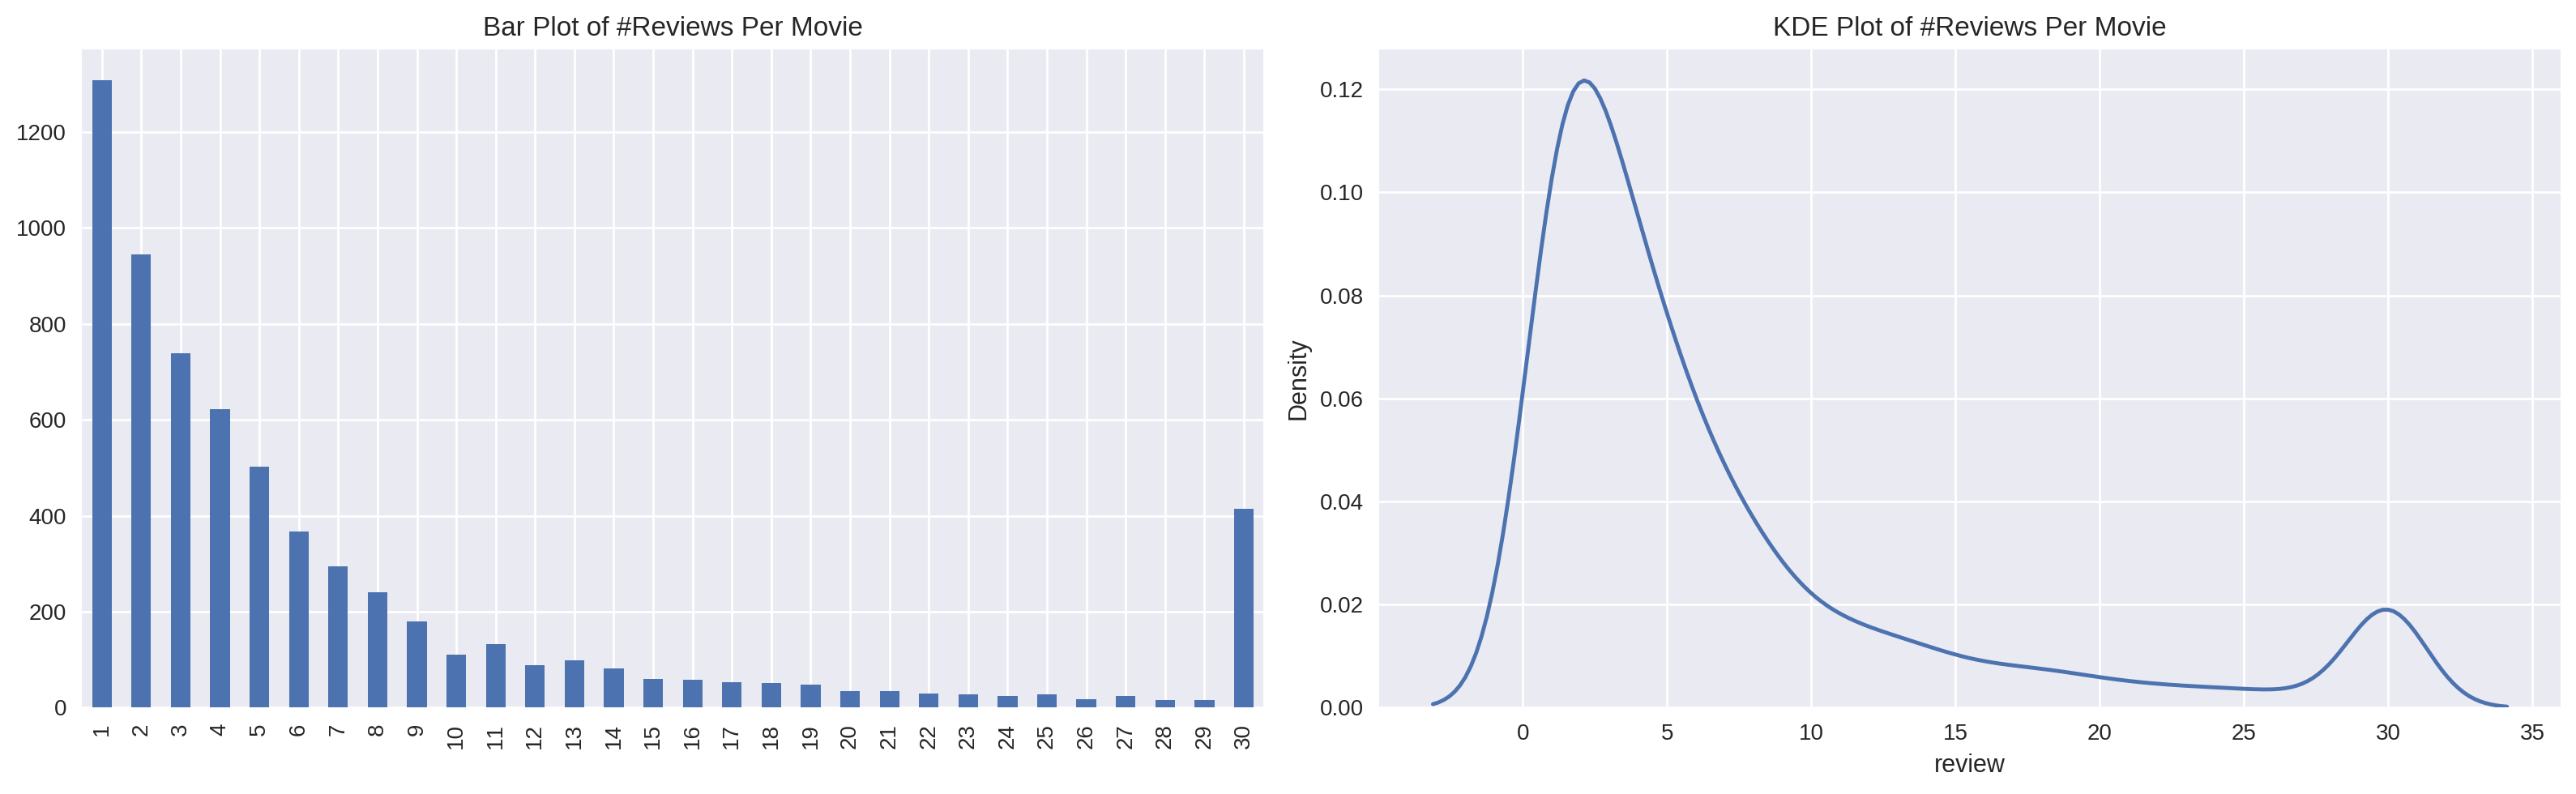

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

From these graphs we can see that the majority of movies have a low number of reviews (e.g., less than 10). Most movies fall into the bin of 1 for the total number of reviews, and the total number of movies tends to decrease with an increase number of reviews. The exception to this is movies with 30 reviews; these movies are presumably some of the most popular represented in the DataFrame. To test this theory, let us use boxplots to visualize the range of ratings of movies grouped by the number of reviews they have.

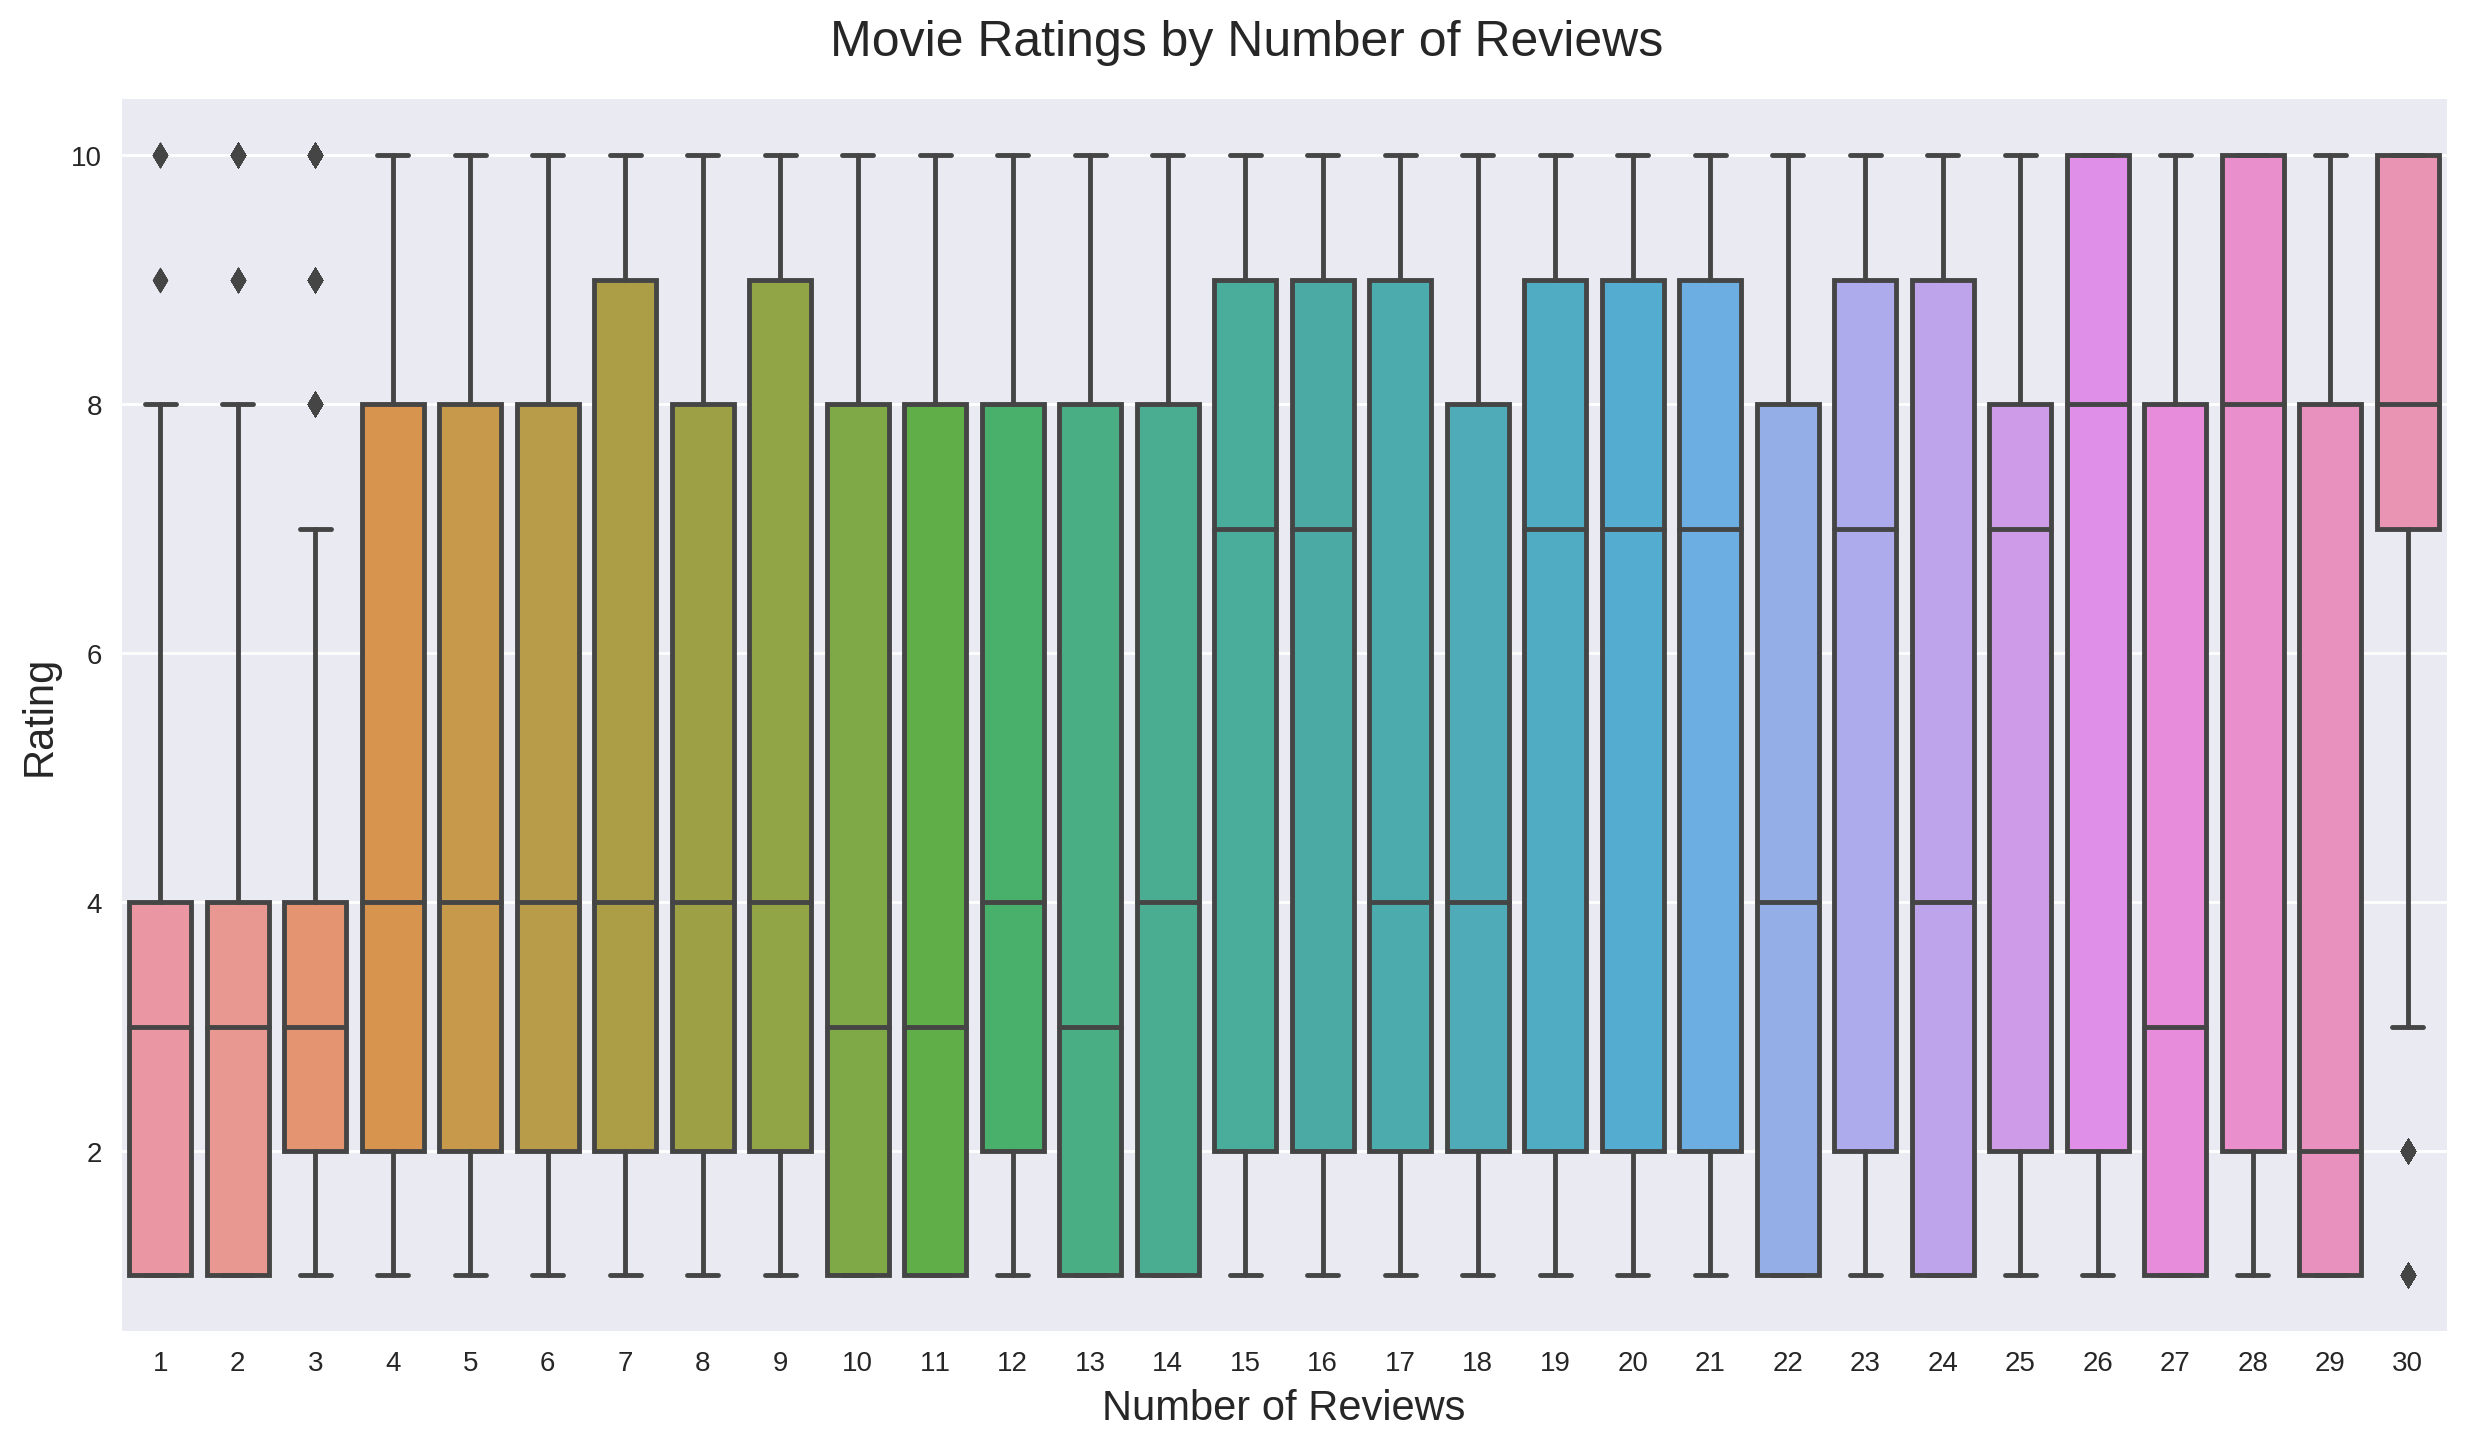

In [11]:
df_reviews['num_rev'] = df_reviews.groupby('tconst')['review'].transform('count')

fig = plt.figure(figsize=(15, 8))
sns.boxplot(x="num_rev", y="rating", data=df_reviews[['num_rev', 'rating']])
fig.suptitle('Movie Ratings by Number of Reviews', fontsize=18, y=.93)
plt.xlabel('Number of Reviews', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.show()

The boxplot analysis shows that movies with a high number of reviews tend to have higher mean ratings compared to those with fewer reviews.

Movies with 1-14 reviews have mean ratings between 3 and 4. Ratings fluctuate more for movies with 15-25 reviews and show a wider range, between 2 and 8, for movies with 25-29 reviews. Notably, movies with 30 reviews have a mean rating of 8 and the highest interquartile range of ratings, suggesting that movies with more reviews are generally more popular and highly rated.

This supports the assumption that movies with more reviews tend to have higher ratings.

In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

In [13]:
print("Total positive and negative reviews: ")
display(df_reviews['pos'].value_counts().reset_index(drop=True))

print('\nTotal positive and negative reviews for training: ')
display(df_reviews.query('ds_part == "train"')['pos'].value_counts().reset_index(drop=True))

print('\nTotal positive and negative reviews for testing: ')
display(df_reviews.query('ds_part == "test"')['pos'].value_counts().reset_index(drop=True))

Total positive and negative reviews: 


0    23715
1    23616
Name: pos, dtype: int64


Total positive and negative reviews for training: 


0    11912
1    11884
Name: pos, dtype: int64


Total positive and negative reviews for testing: 


0    11803
1    11732
Name: pos, dtype: int64

As we can see here, there are roughly an equal number of positive and negative reviews in our dataset. This is good, as we will not have to balance the datasets by up/downsampling

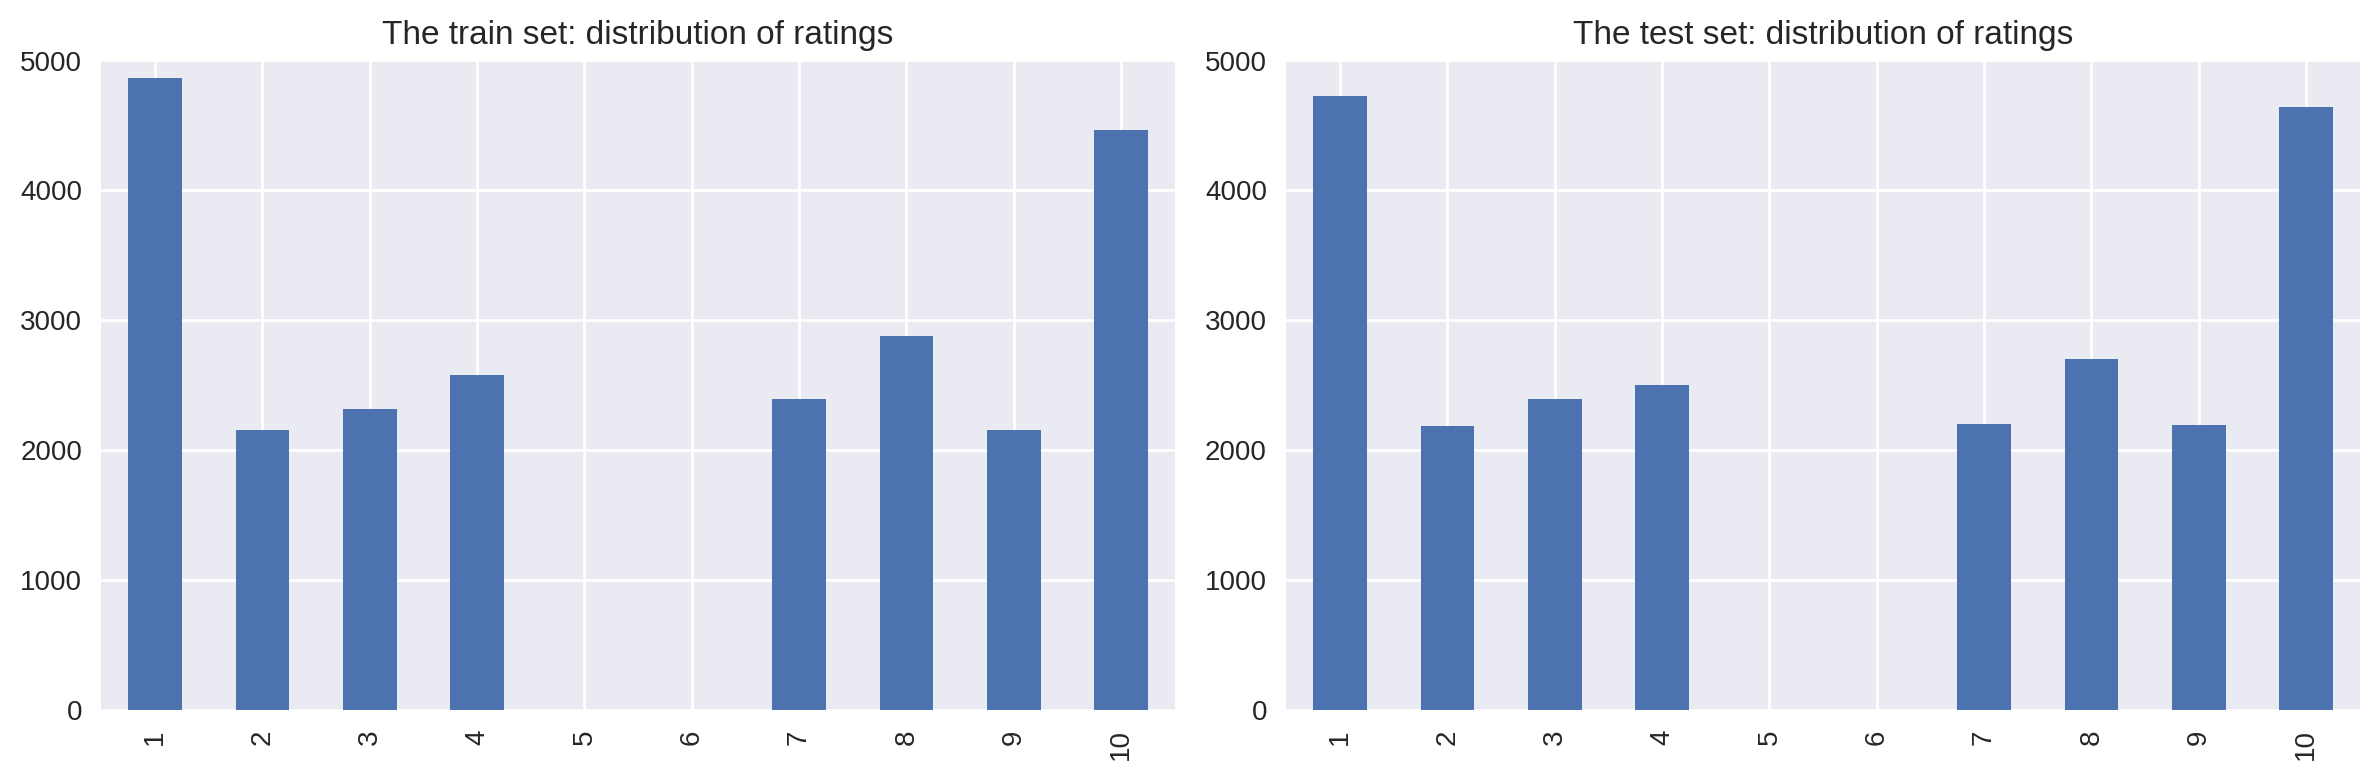

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The reviews chosen appear to all have come from individuals who rated the relevant movies as between 1 and 4 or between 7 and 10; there are no reviews with ratings of 5 or 6 in this dataset. While this may be good for building our models, it might affect the real-world accuracy of our model, as ratings of 5 or 6 might be accompanied by reviews that offer both positive and negative takes on the respective movie; if this is the case, then our model might not be able to properly classify a review as positive or negative.

As one more point of analysis, let us visualize the number of reviews of different polarities (pos or negative) per year in both the training and testin dataset. This might not be essential information when it comes to building our later model, but it could be a useful bit of information if one were to develop a model for predicting whether a review is positive or negative by also takign into account the year a movie was released.

Distribution of negative and positive reviews over the years for two parts of the dataset

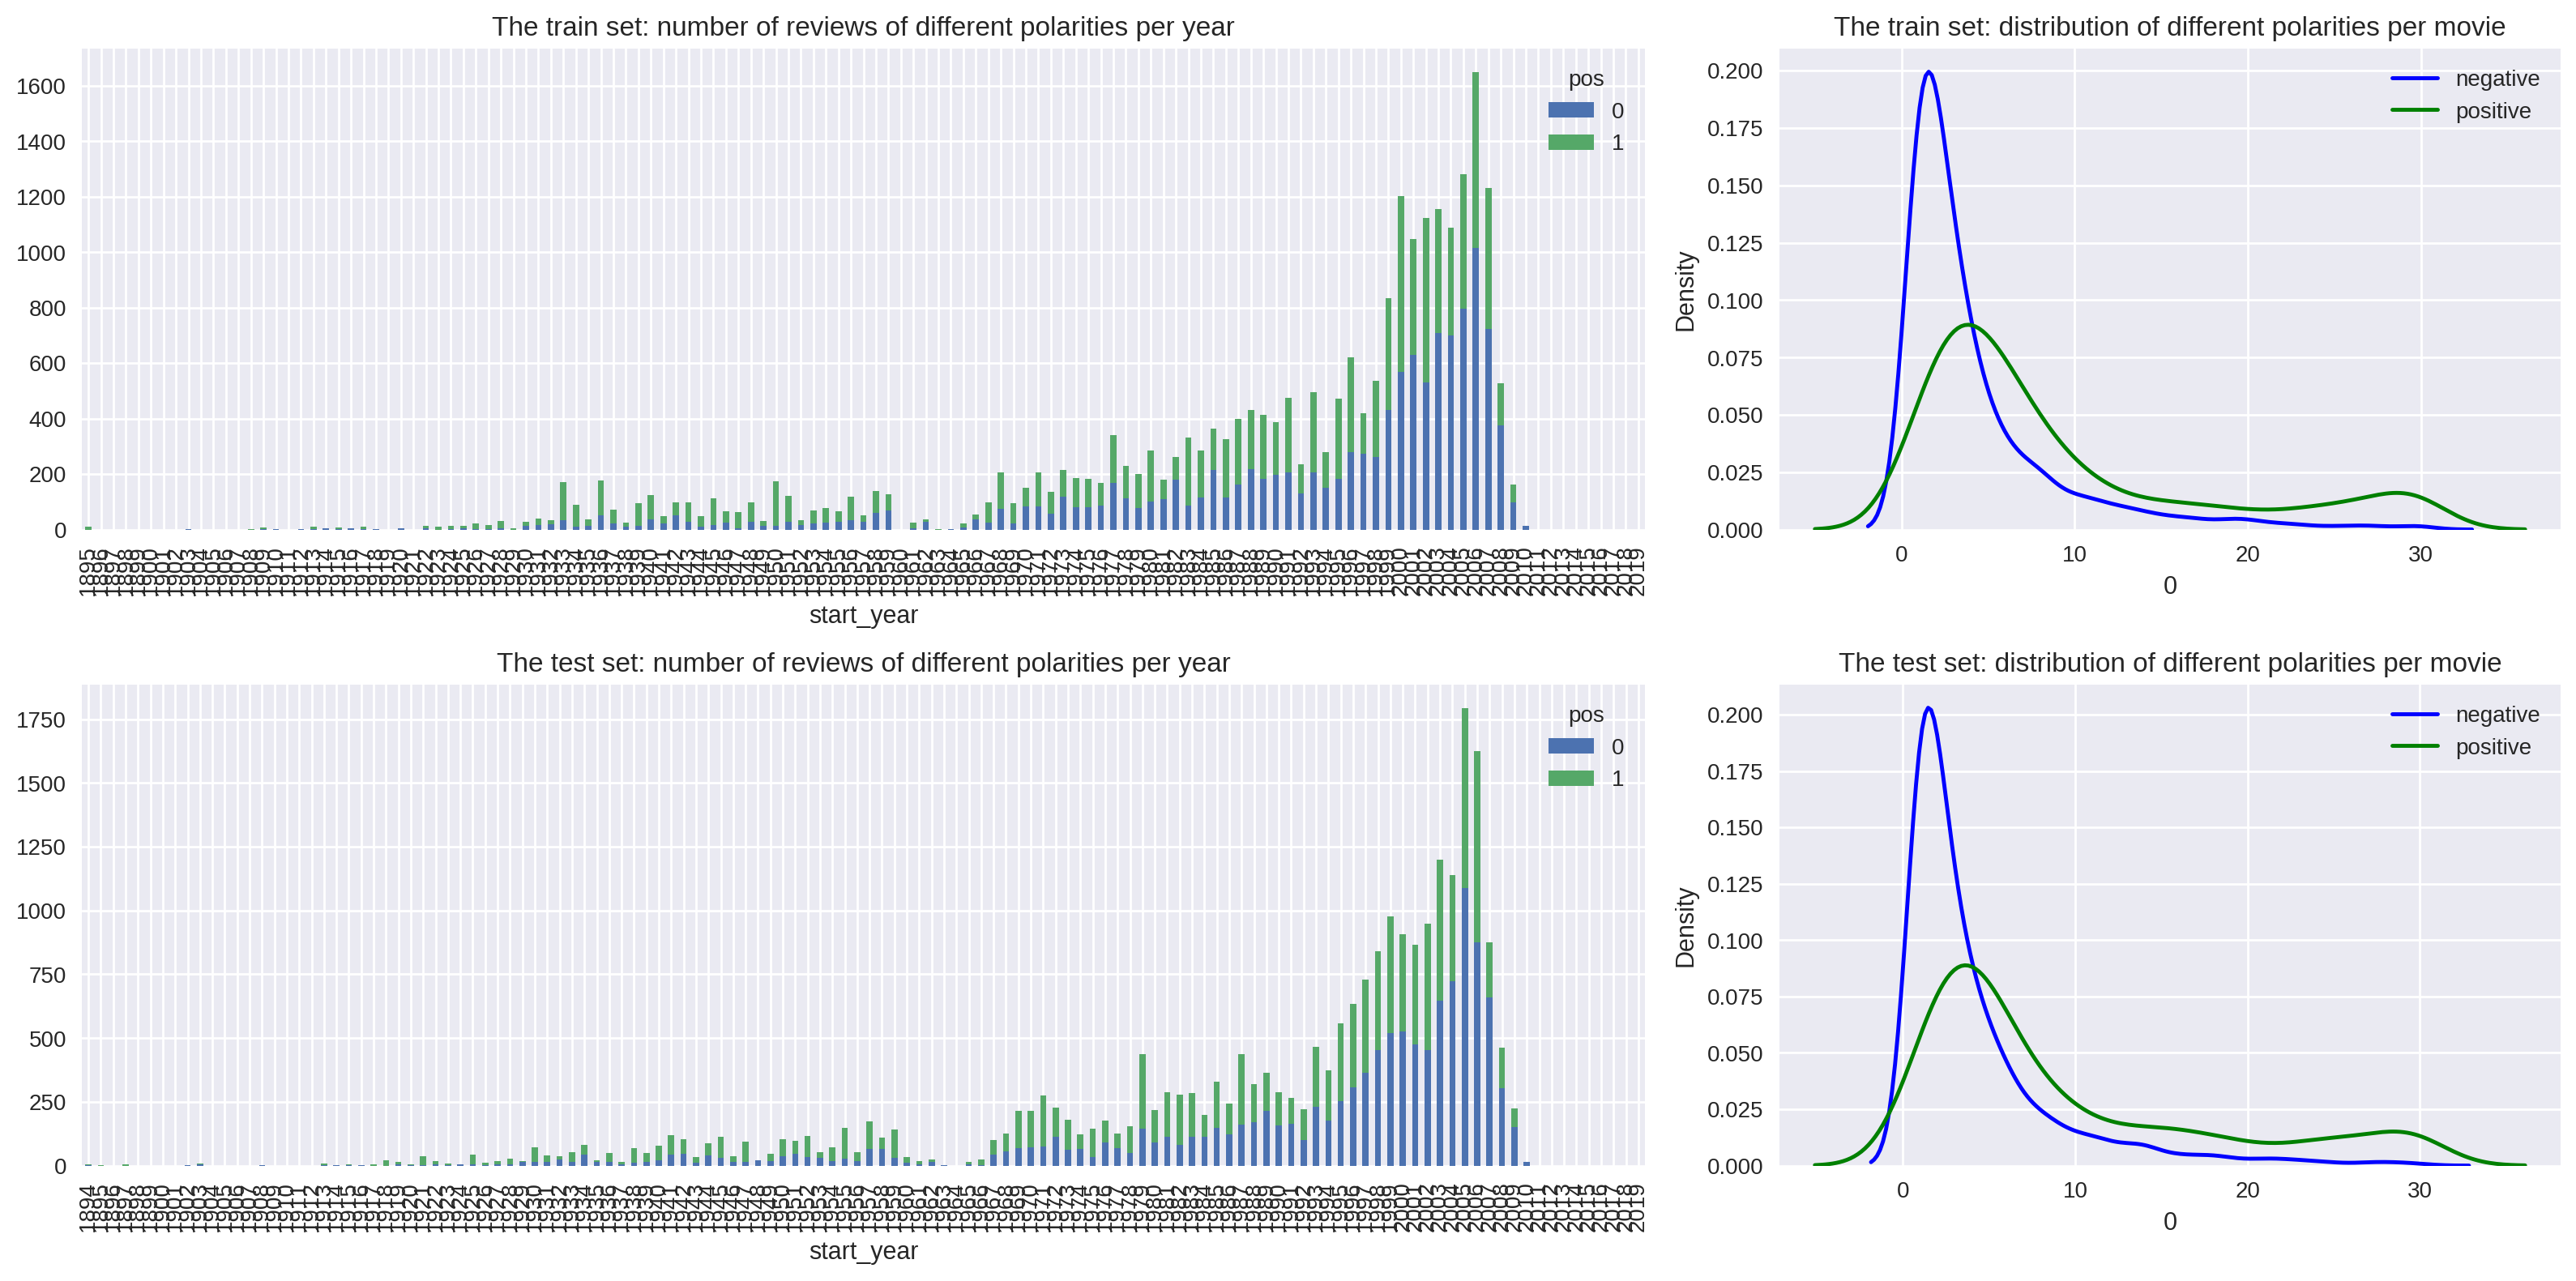

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

From these plots we can see that the number of reviews made greatly increased over the last two decades.

Regarding the distribution of reviews, it appears that the ratio of positive to negative reviews became more equalized with later release dates, except for movies released over the last couple of years. From the KDE plot, we see that there is a greater proportion of negative reviews for movies with fewer reviews than for those with a high-number of reviews.

We see a similar pattern with positive reviews, though it appears that for each dataset the probability of a review being positive is higher than the probability of it being negative for movies with 5 or more reviews.

Overall, the distribution of reviews, as well as the distribution of positive to negative reviews, appears very similar for both training and testing datasets.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Good job!
</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'ROC Curve')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [17]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [18]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Correct
</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 19)
(23535, 19)


## Working with models

### Model 0 - Constant

In [20]:
model_0 = DummyClassifier(strategy='most_frequent')

In [21]:
model_0.fit(df_reviews_train['review_norm'].values.reshape(-1, 1), train_target)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


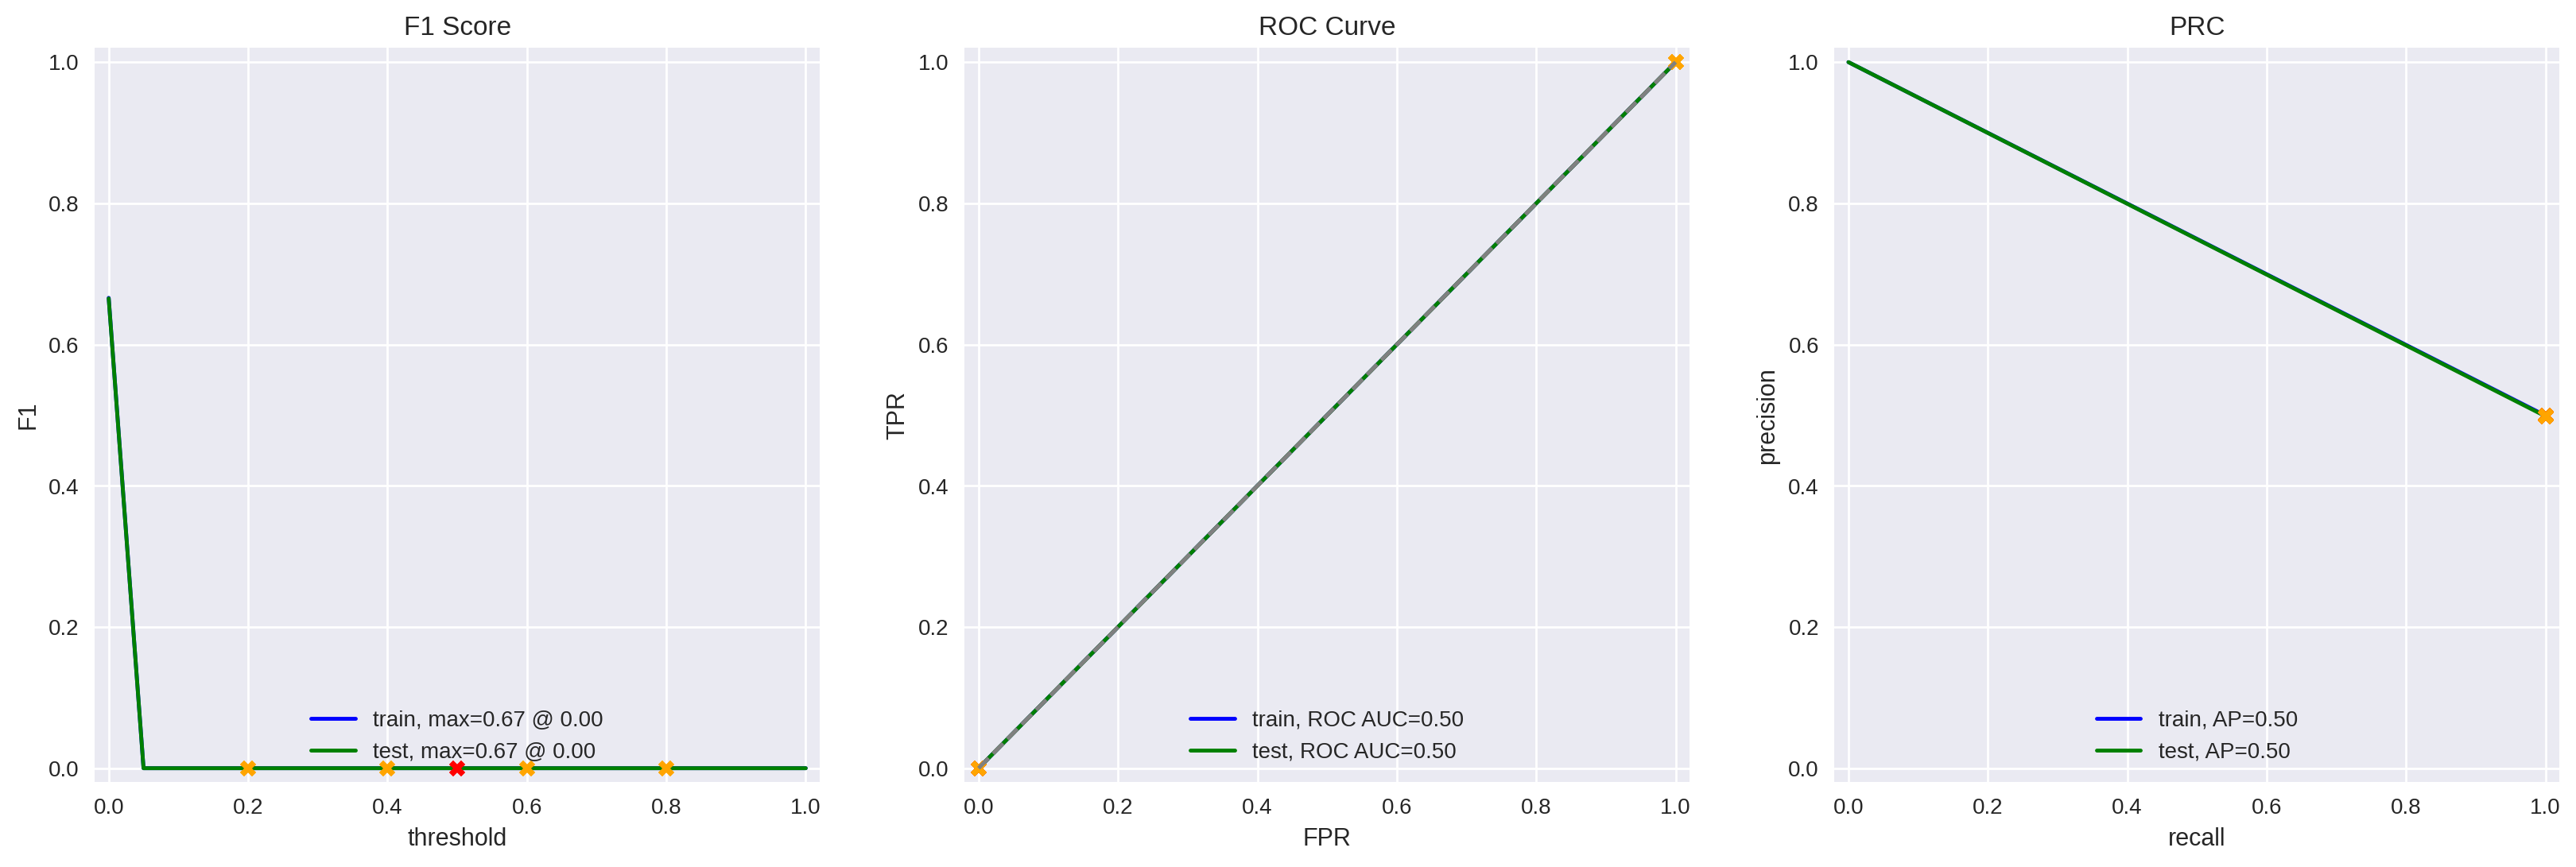

In [22]:
evaluate_model(model_0, df_reviews_train['review_norm'].values.reshape(-1, 1), train_target, df_reviews_test['review_norm'].values.reshape(-1, 1), test_target)

As expected, our dummy model 'predicted' the correct answers with an accuracy score of .5 in both the training and testing sets.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Correct
</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [38]:
stop_words = list(stopwords.words('english'))
tfidf_vectorizer_1  = TfidfVectorizer(stop_words=stop_words)
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

In [39]:
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


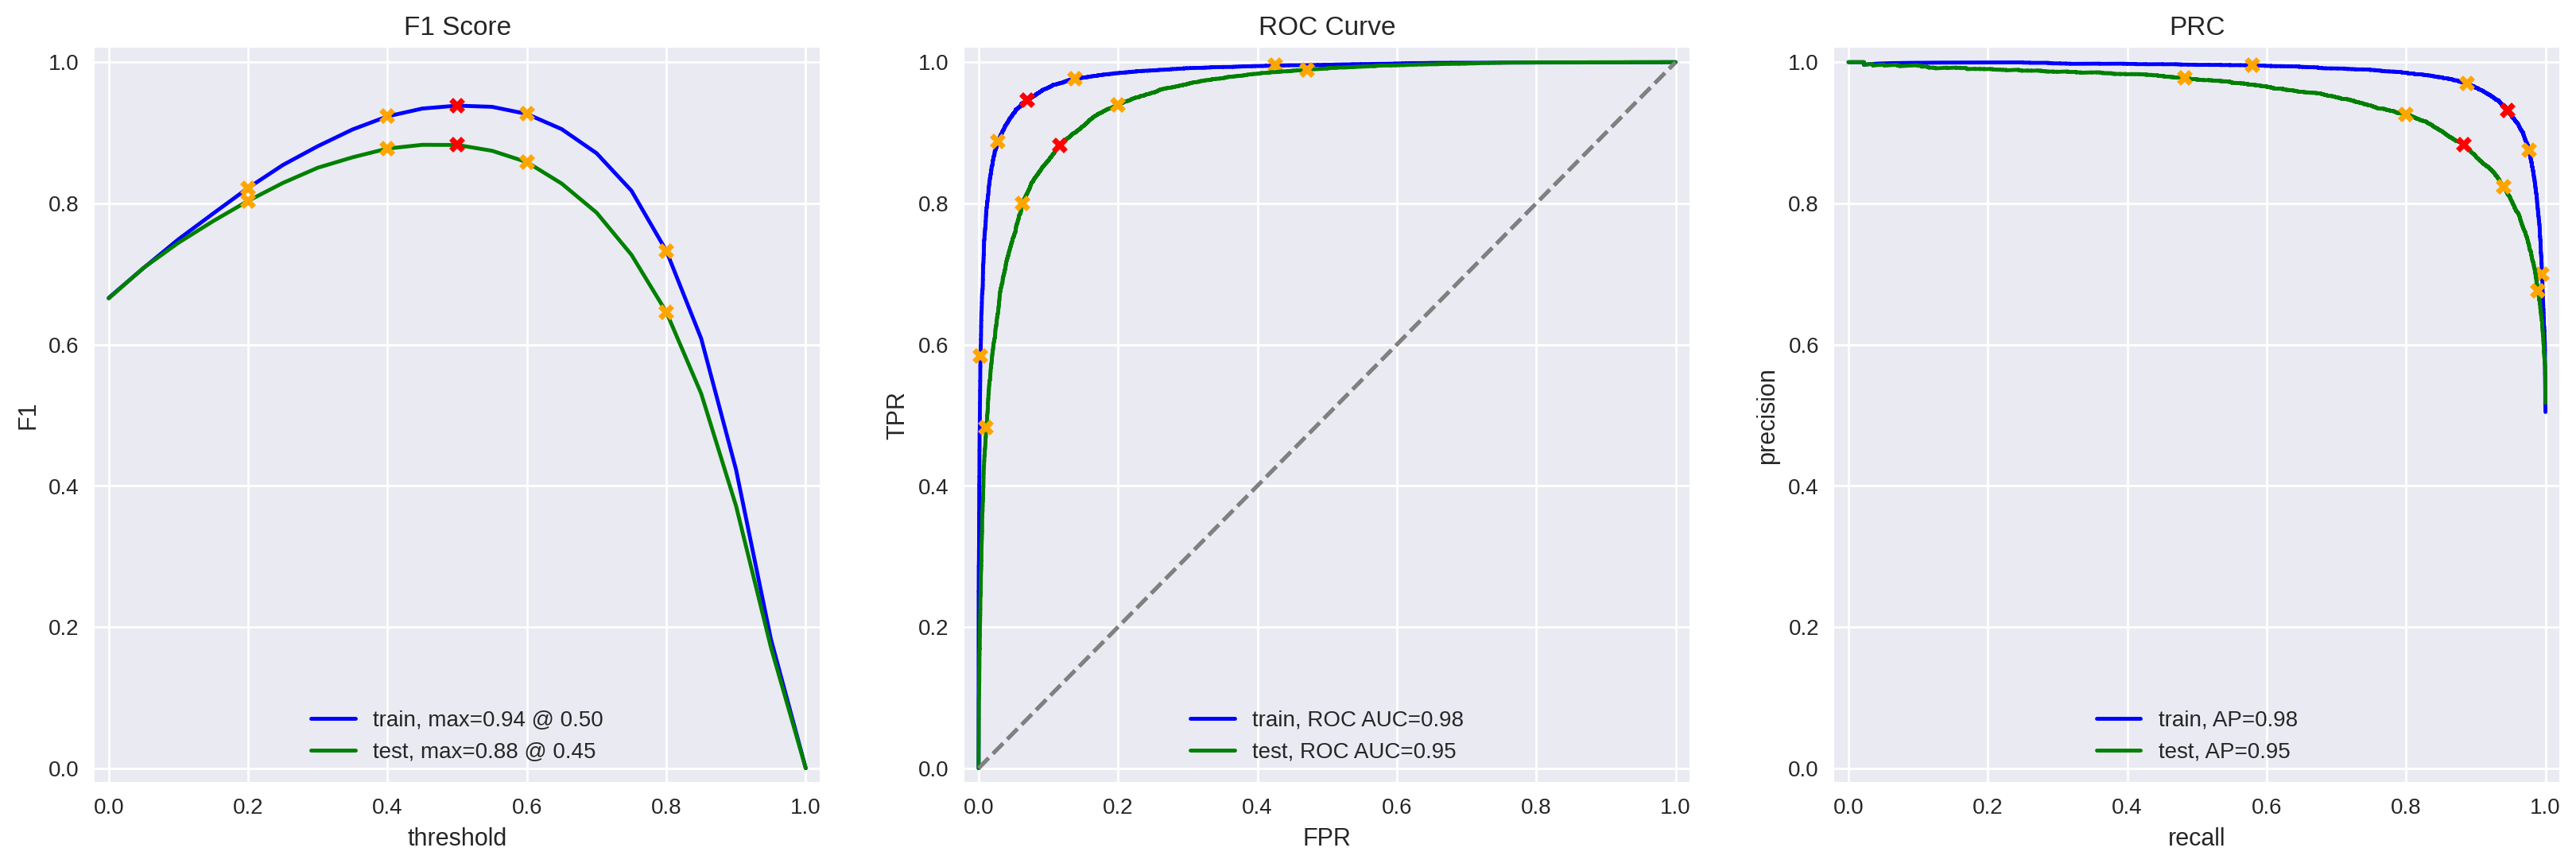

In [40]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

As we can see from the plots, our logistic regression model performed far better than the dummy model.

the score for the training set was higher than the testing set; nonetheless, our test set produced a score of .88, which is higher than the minimum score specified by the company (i.e., .85).

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Correct
</div>

### Model 3 - spaCy, TF-IDF and LR

In [26]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
def text_preprocessing_3(text):

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return ' '.join(tokens)

In [28]:
df_train_spacy = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_test_spacy = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [29]:
train_features_3 = tfidf_vectorizer_1.fit_transform(df_train_spacy)
test_features_3 = tfidf_vectorizer_1.transform(df_test_spacy)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


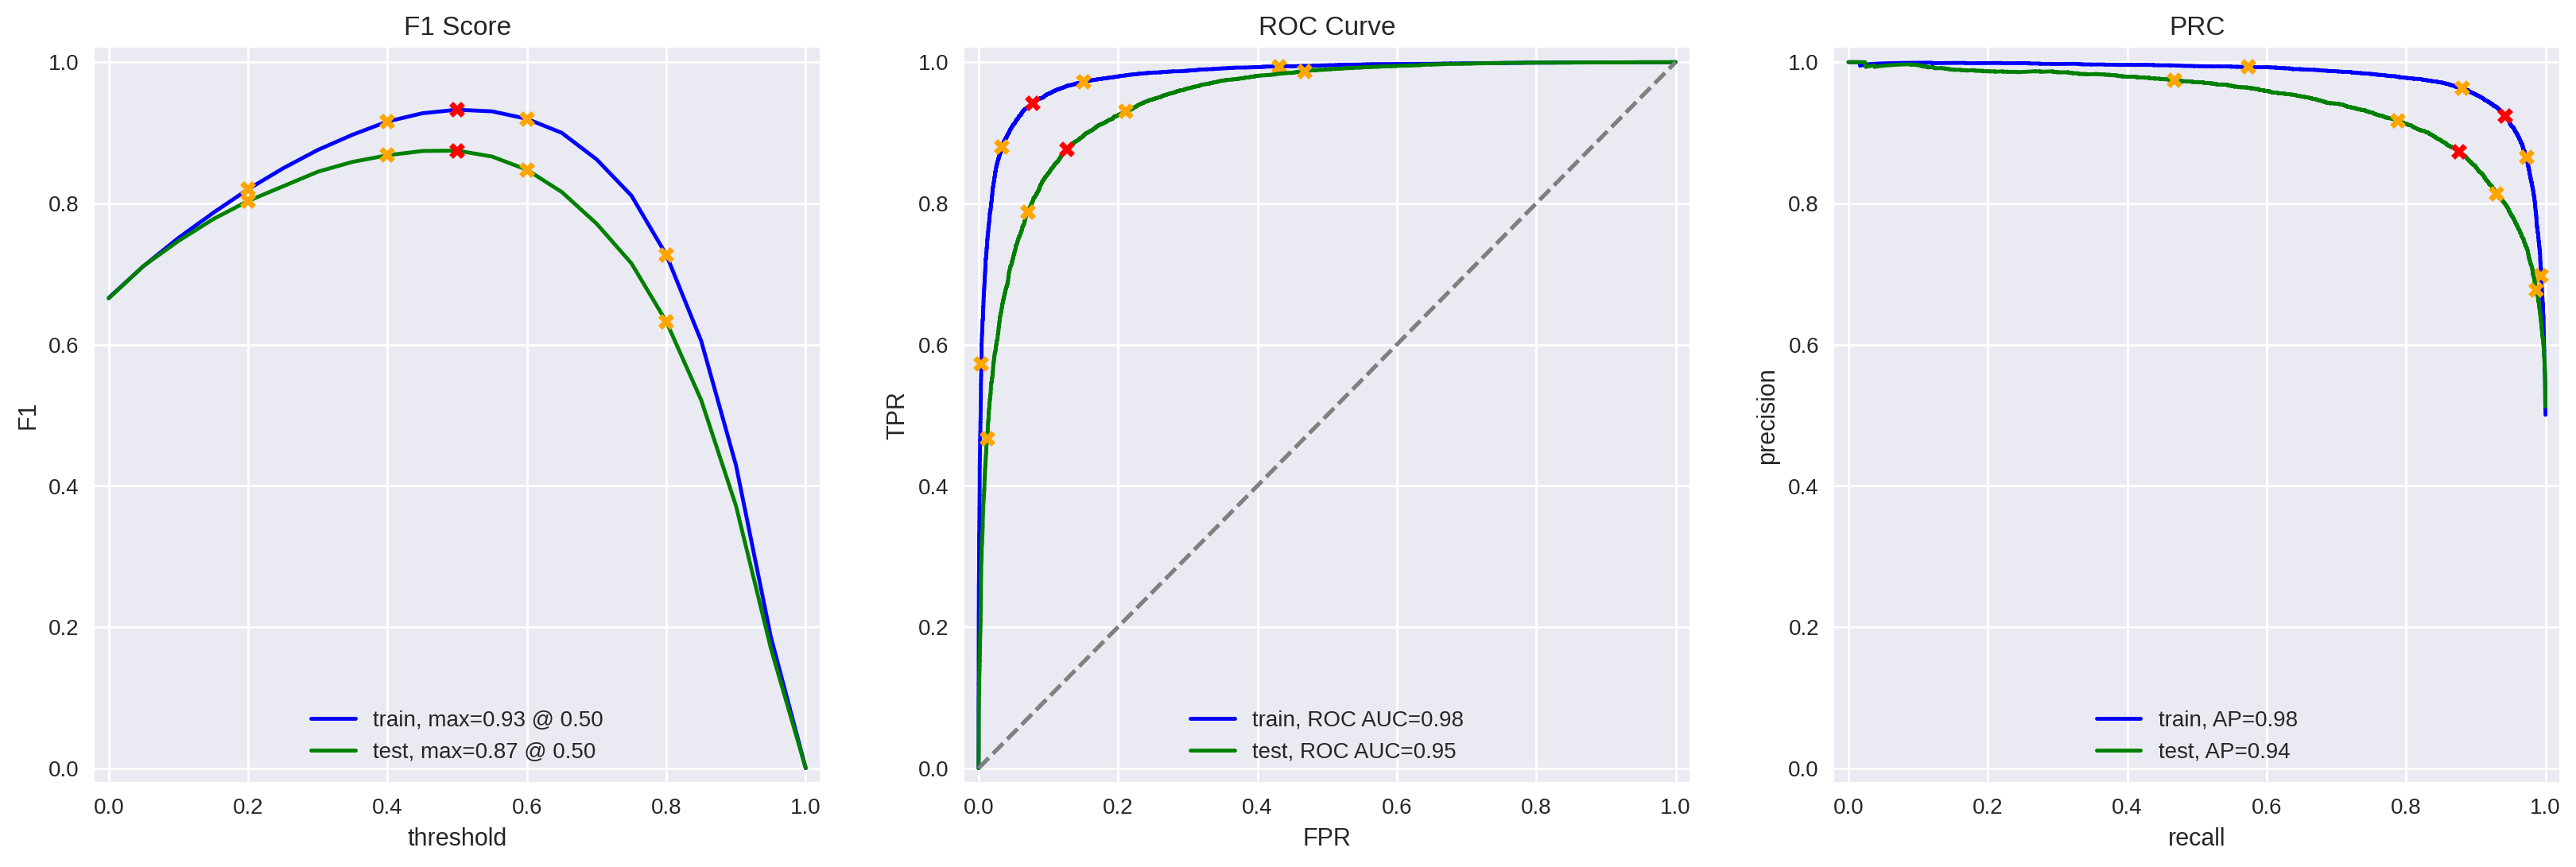

In [30]:
model_3 = LogisticRegression()
model_3.fit(train_features_3, train_target)
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

It appears that our logistic regression model, when tokenized using spaCy to tokenize the reviews, provides slightly lower accuracy and F1 scores than the same model where we tokenized reviews using NLTK.

The difference in the scores between the two models is approxomately .01 points for each metric, which is quite small. This model meets the minimum-score criteria specified by the Film Junky Union.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Correct
</div>

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [31]:
model_4 = LGBMClassifier()
model_4.fit(train_features_3, train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


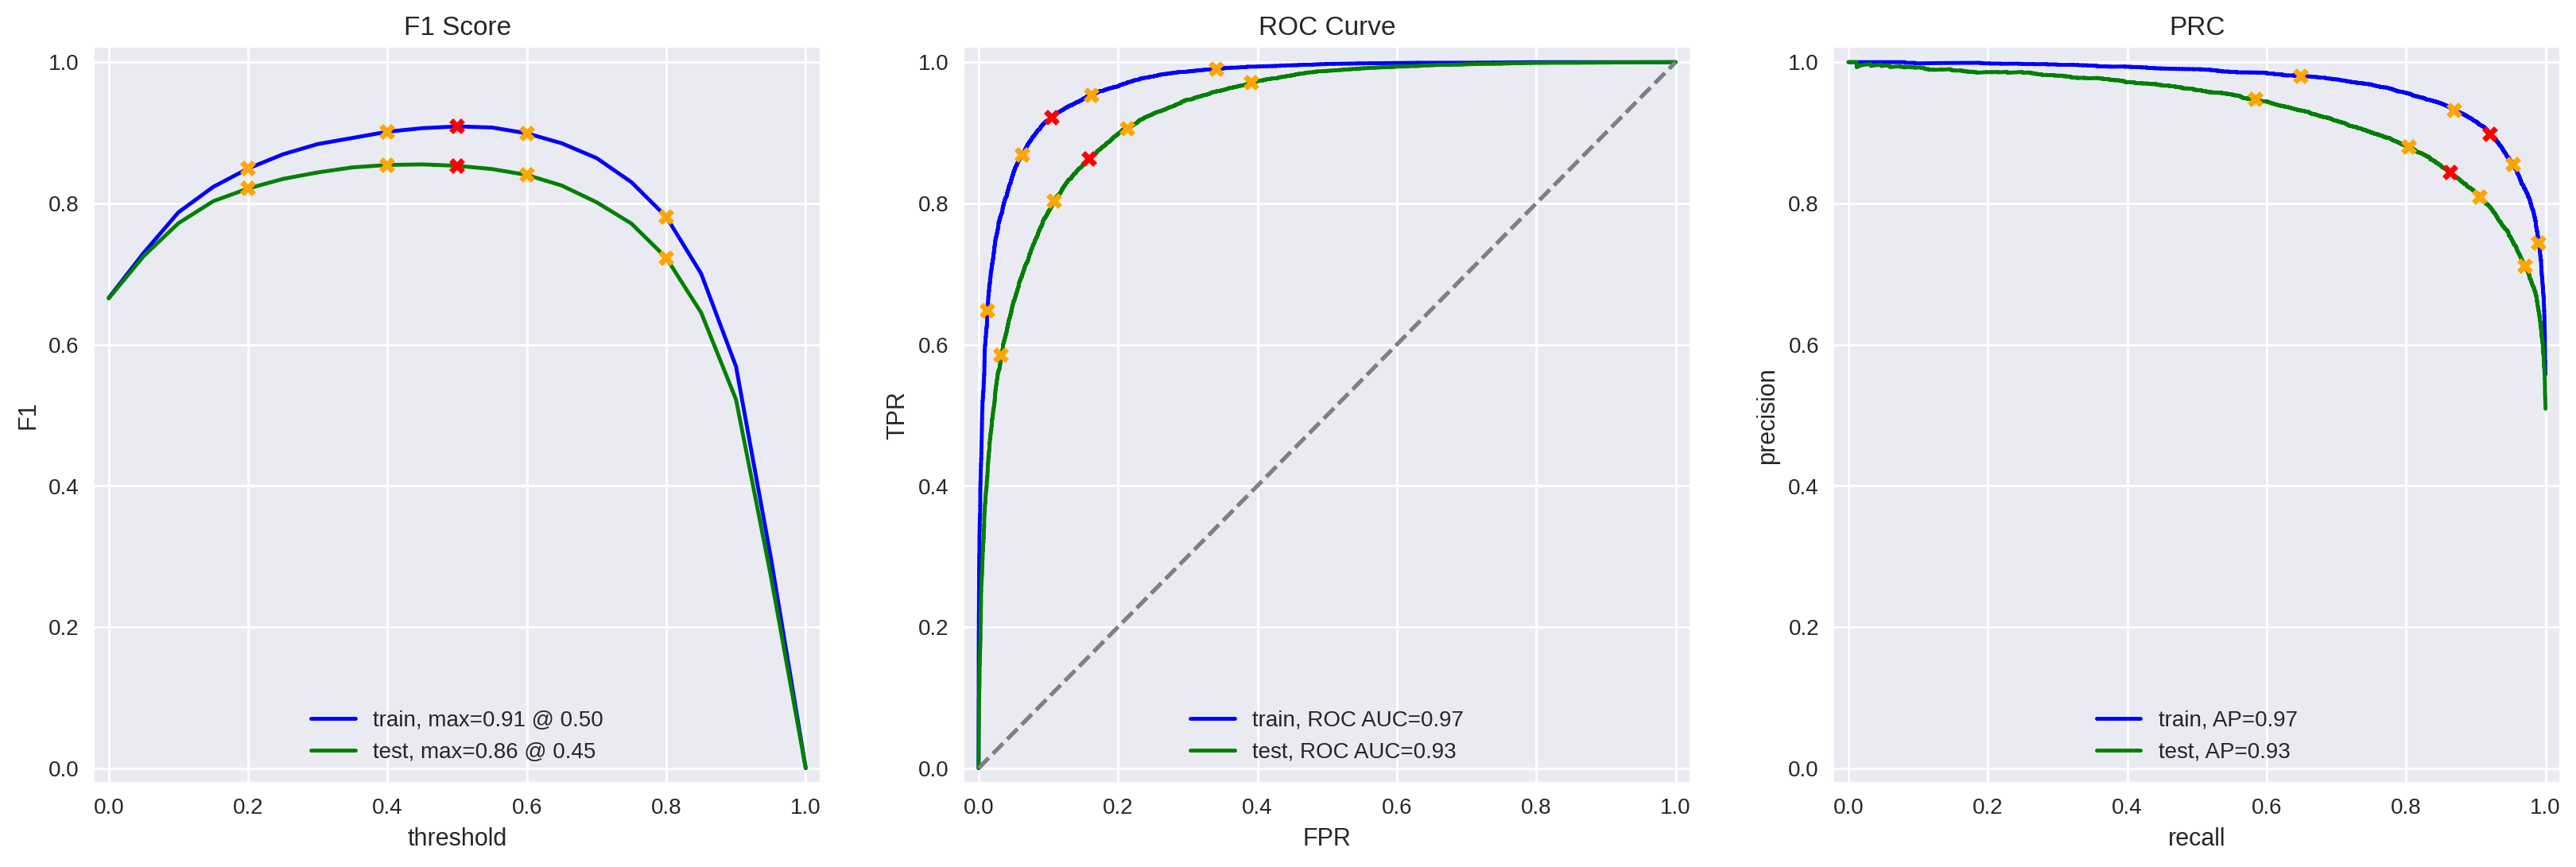

In [32]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

It appears that our LGBMClassifier does not perform as well as our previous model. Using the same datasets, the Logistic Regression model provides higher scores for each metric than our LGBM Classifier model.

The LGBM Classifier model's F1 score for the testing dataset is .85, which meets the Film Junky Union's minimum threshold score for a review classification model.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Correct
</div>

###  Model 9 - BERT

Trained in google colab

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=20, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    for text in tqdm(texts, disable=disable_progress_bar):
        tokens = tokenizer.encode_plus(
            text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        ids_list.append(tokens['input_ids'])
        attention_mask_list.append(tokens['attention_mask'])

    # Convert lists to tensors
    ids_tensor = torch.cat(ids_list, dim=0)
    attention_mask_tensor = torch.cat(attention_mask_list, dim=0)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = ids_tensor[batch_size*i:batch_size*(i+1)].to(device)
        attention_mask_batch = attention_mask_tensor[batch_size*i:batch_size*(i+1)].to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

  0%|          | 0/23796 [00:00<?, ?it/s]

Using the cuda device.


  0%|          | 0/1190 [00:00<?, ?it/s]

In [ ]:
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

  0%|          | 0/23535 [00:00<?, ?it/s]

Using the cuda device.


  0%|          | 0/1177 [00:00<?, ?it/s]

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


In [ ]:
model_9 = LogisticRegression()  # You can use other classifiers as well
model_9.fit(train_features_9, train_target)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

          train  test
Accuracy   0.87  0.86
F1         0.87  0.86
APS        0.95  0.94
ROC AUC    0.94  0.94


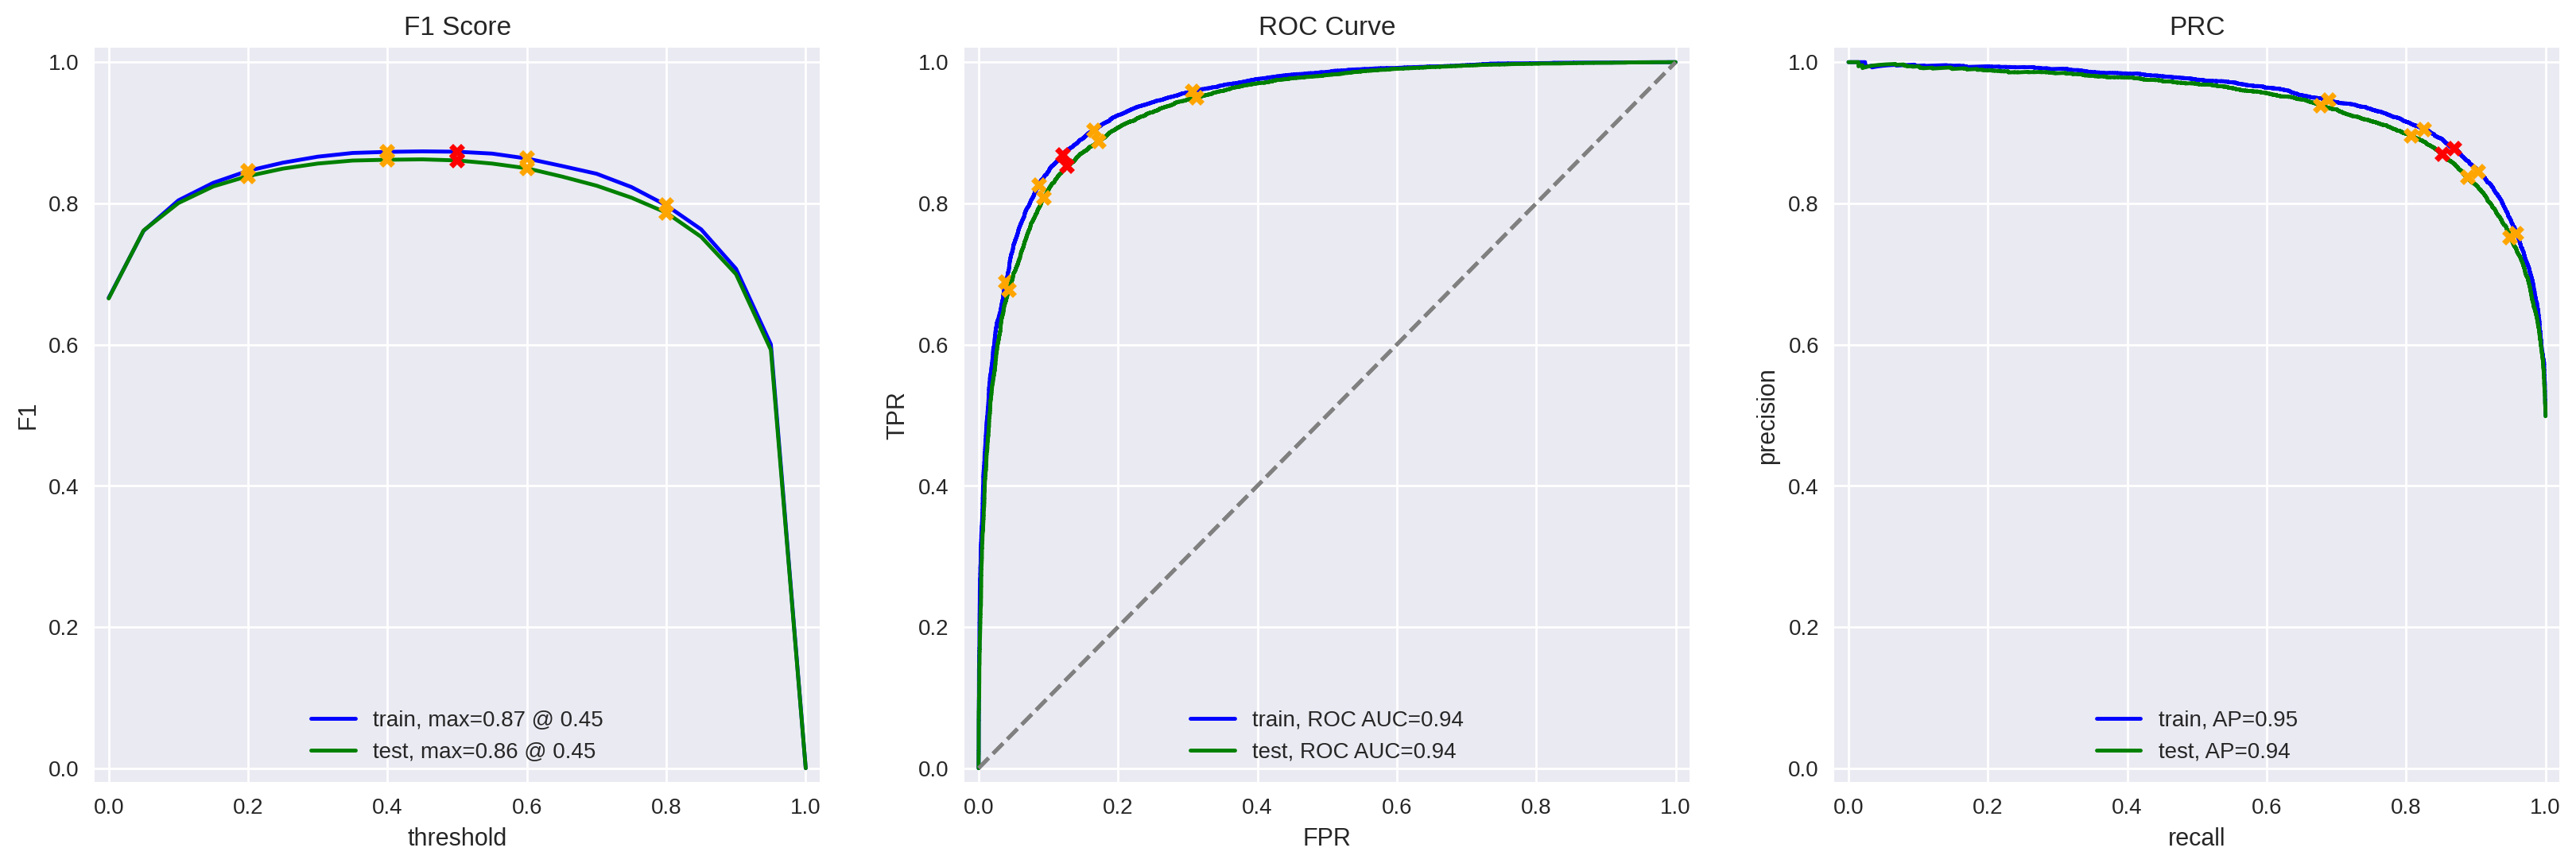

In [ ]:
evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)

From our results we can see that the BERT + LR model meets the Film Junky Union's standards for a review classifying model. Our model, while only providing an F1 score of .86, is better than our LGBM Classifier model, and provided similar scores to the logistic regression models tokenized with NLTK and spaCy.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Nice try! It's a common situation when pretrained bert works worse than tf-idf + logreg. But if you finetune the bert on your data most likely it will work better then classical ml models.
</div>

## My Reviews

In [33]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [34]:
my_reviews = pd.DataFrame([
    'I hated this movie. I expected more and was really dissapointed',
    'This movie made me fall asleep in the theater. It was pretty boring.',
    'It is not every day that you come across such a captivating and amazing movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'Trillogies aren\'t often good, which is why I was so surprised how great this movie was!',
    'This is a movie I could take or leave. It was not the most amazing, but it was still enjoyable. I would watch it again.',
    'This movie just rehashed the same old, tired jokes as every other b-movie film. It lacked originality and was of poor quality overall.',
    'I am usually hesitant with starting new series, but I fell in love with this one instantly. After the first episode I could not stop! I loved every season and hope they make more'
], columns=['review'])

my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1]

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

display(my_reviews.head())

,review,pos,review_norm
0,I hated this movie. I expected more and was re...,0,i hated this movie i expected more and was rea...
1,This movie made me fall asleep in the theater....,0,this movie made me fall asleep in the theater ...
2,It is not every day that you come across such ...,1,it is not every day that you come across such ...
3,Even the actors looked really old and disinter...,0,even the actors looked really old and disinter...
4,"Trillogies aren't often good, which is why I w...",1,trillogies arent often good which is why i was...


### Model 1

In [41]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review[:50]}')

Actual: 0 | Predicted: 0 | Text: i hated this movie i expected more and was really 
Actual: 0 | Predicted: 0 | Text: this movie made me fall asleep in the theater it w
Actual: 1 | Predicted: 1 | Text: it is not every day that you come across such a ca
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disintereste
Actual: 1 | Predicted: 1 | Text: trillogies arent often good which is why i was so 
Actual: 1 | Predicted: 1 | Text: this is a movie i could take or leave it was not t
Actual: 0 | Predicted: 0 | Text: this movie just rehashed the same old tired jokes 
Actual: 1 | Predicted: 1 | Text: i am usually hesitant with starting new series but


which we found to have the highest F1 score on the testing datasets in the previous section, has accurately predicted the sentiment of each review.

### Model 3

In [36]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_1.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review[:50]}')

Actual: 0 | Predicted: 0 | Text: i hated this movie i expected more and was really 
Actual: 0 | Predicted: 0 | Text: this movie made me fall asleep in the theater it w
Actual: 1 | Predicted: 1 | Text: it is not every day that you come across such a ca
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disintereste
Actual: 1 | Predicted: 1 | Text: trillogies arent often good which is why i was so 
Actual: 1 | Predicted: 1 | Text: this is a movie i could take or leave it was not t
Actual: 0 | Predicted: 0 | Text: this movie just rehashed the same old tired jokes 
Actual: 1 | Predicted: 1 | Text: i am usually hesitant with starting new series but


Model 3 has accurately predicted the sentiment for each of our 'fake' reviews

### Model 4

In [37]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_1
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review[:50]}')

Actual: 0 | Predicted: 1 | Text: i hated this movie i expected more and was really 
Actual: 0 | Predicted: 0 | Text: this movie made me fall asleep in the theater it w
Actual: 1 | Predicted: 1 | Text: it is not every day that you come across such a ca
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disintereste
Actual: 1 | Predicted: 1 | Text: trillogies arent often good which is why i was so 
Actual: 1 | Predicted: 1 | Text: this is a movie i could take or leave it was not t
Actual: 0 | Predicted: 0 | Text: this movie just rehashed the same old tired jokes 
Actual: 1 | Predicted: 1 | Text: i am usually hesitant with starting new series but


model 4 did not accurately predict the sentiment for each review.

While it only misclassified one review, we are disheartened by the fact that our model classified the review, which contains the words "hate" and "dissapointed", as positive.

These words are often strong signifiers of negative sentiment; as such, we would expect a sentiment analysis model to accurately classify such a review as negative.

### Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if my_reviews_pred_prob[i] < .5 else 1} | Text: {review[:50]}')

Actual: 0 | Predicted: 0 | Text: i hated this movie i expected more and was really 
Actual: 0 | Predicted: 1 | Text: this movie made me fall asleep in the theater it w
Actual: 1 | Predicted: 1 | Text: it is not every day that you come across such a ca
Actual: 0 | Predicted: 0 | Text: even the actors looked really old and disintereste
Actual: 1 | Predicted: 1 | Text: trillogies arent often good which is why i was so 
Actual: 1 | Predicted: 1 | Text: this is a movie i could take or leave it was not t
Actual: 0 | Predicted: 0 | Text: this movie just rehashed the same old tired jokes 
Actual: 1 | Predicted: 1 | Text: i am usually hesitant with starting new series but


Similarly to the previous model, Model 9 misclassified one review. While the review it misclassified was not as overtly negative as the review misclassified by Model 4, it nonetheless included the words "boring" and "sleep", which are also often found to convey negative sentiments towards a movie.

### Overall

In this section we tested each model built in the previous section on reviews we wrote ourselves. As it turns out, only one of the four models (Model 1 and model 3) accurately predicted the sentiment of each review. Models 4 and 5 each misclassified one review and positive when the actual sentiment was negative.

This difference in predictive accuracy is reflected by the F1 scores of models 1 and 3 being higher than those of models 4 and 5.

## Conclusions

The project's goal was to develop an NLP machine learning model to classify movie reviews as positive or negative, achieving an F1 score of at least 0.85. The process included data preprocessing to clean the reviews and exploratory data analysis to ensure balanced classes in the training and testing datasets.

Several models were built and tested:

- Dummy Classifier
- NLTK + TF-IDF + Logistic Regression
- spaCy + TF-IDF + Logistic Regression
- spaCy + TF-IDF + LGBMClassifier
- BERT + Logistic Regression

While higher-numbered models took longer to train due to their complexity, it was expected they would perform better. However, Model 1 (NLTK + TF-IDF + Logistic Regression) performed the best overall with an F1 score of 0.88. The F1 scores for each model on the testing datasets were:

- Model 0: 0.00
- Model 1: 0.88
- Model 3: 0.87
- Model 4: 0.85
- Model 9: 0.86

Aside from model 0, all models met the minimum F1 threshold of 0.85. Given its highest score and quick training time, Model 1 is recommended for the Film Junky Union. For further improvement, especially if time permits, experimenting with BERT embeddings and hyperparameters on a larger dataset could potentially enhance Model 9's performance, aligning with industry standards for NLP.

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

You did a great job! Everything is correct and your code looks really nice and professional. I like your work:)
</div>

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions